In [1]:
import sys
from pathlib import Path
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT / "src"))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.stats import gaussian_kde
from scipy.stats import norm

plt.style.use("rotskoff_notebook.mplstyle")

In [2]:
############## LOAD EXPLICIT SOLVENT DATA - RAW, TWO-STEP and MULTICONFIGURATIONAL RESP ###################

MICROSTATES = ["HIP", "HIE", "HID"]

RESULTS_ROOT = ROOT / "results"

mm_file = np.load(
    RESULTS_ROOT / "mmresp_hist" / "charges.npz",  # adjust path if needed
    allow_pickle=True
)

mm_by_mol = mm_file["charges_final_by_mol"][()]        # dict: {"PRN_prot": array(...), ...}


hydro_dataset = {}; oxygen_dataset = {}; nitrogen_dataset = {}; carbon_dataset = {}

for state in MICROSTATES:
    base = RESULTS_ROOT / state
    labels = np.load(base / "rawESP" / "charges_constraint_multi.npz", allow_pickle=True)["labels"].astype(str)
    esp_charges = np.load(base / "rawESP" / "charges_constraint_multi.npz", allow_pickle=True)["charges"]
    tsresp_charges = np.load(base / "twostepRESP_frozen_buckets" / "charges_constraint.npz", allow_pickle=True)["step2"]
    mcresp_charges = np.load(base / "multiconfRESP_reduced_group_constraints" / "charges_final.npy", allow_pickle=True)

    # ---- build mmRESP charges aligned to *these* labels ----
    # mm_by_mol[state] is the mm charges in the same order as mm_labels
    mm_state_array = mm_by_mol[state]  # 1D array

    if len(mm_state_array) != len(labels):
        raise ValueError(f"Length mismatch for {state}: labels={len(labels)}, mm={len(mm_state_array)}")

    mmresp_charges = mm_state_array


    mask_h = (np.char.startswith(labels, "H") & ~np.isin(labels, ["HH31", "HH32", "HH33", "H", "H3", "HA", "HB2", "HB3"]))
    hydro_dataset[state] = {
        "labels": labels[mask_h],
        "raw_charges": esp_charges[mask_h],
        "tsresp_charges": tsresp_charges[mask_h],
        "mcresp_charges": mcresp_charges[mask_h],
        "mmresp_charges":mmresp_charges[mask_h],
    }

    mask_n = (np.char.startswith(labels, "N") & ~np.isin(labels, ["N", "N3"]))
    nitrogen_dataset[state] = {
        "labels": labels[mask_n],
        "raw_charges": esp_charges[mask_n],
        "tsresp_charges": tsresp_charges[mask_n],
        "mcresp_charges": mcresp_charges[mask_n],
        "mmresp_charges":mmresp_charges[mask_n],
    }

    mask_c = (np.char.startswith(labels, "C") & ~np.isin(labels, ["CH3", "C1", "C", "CA", "CB"]))
    carbon_dataset[state] = {
        "labels": labels[mask_c],
        "raw_charges": esp_charges[mask_c],
        "tsresp_charges": tsresp_charges[mask_c],
        "mcresp_charges": mcresp_charges[mask_c],
        "mmresp_charges":mmresp_charges[mask_c],
    }


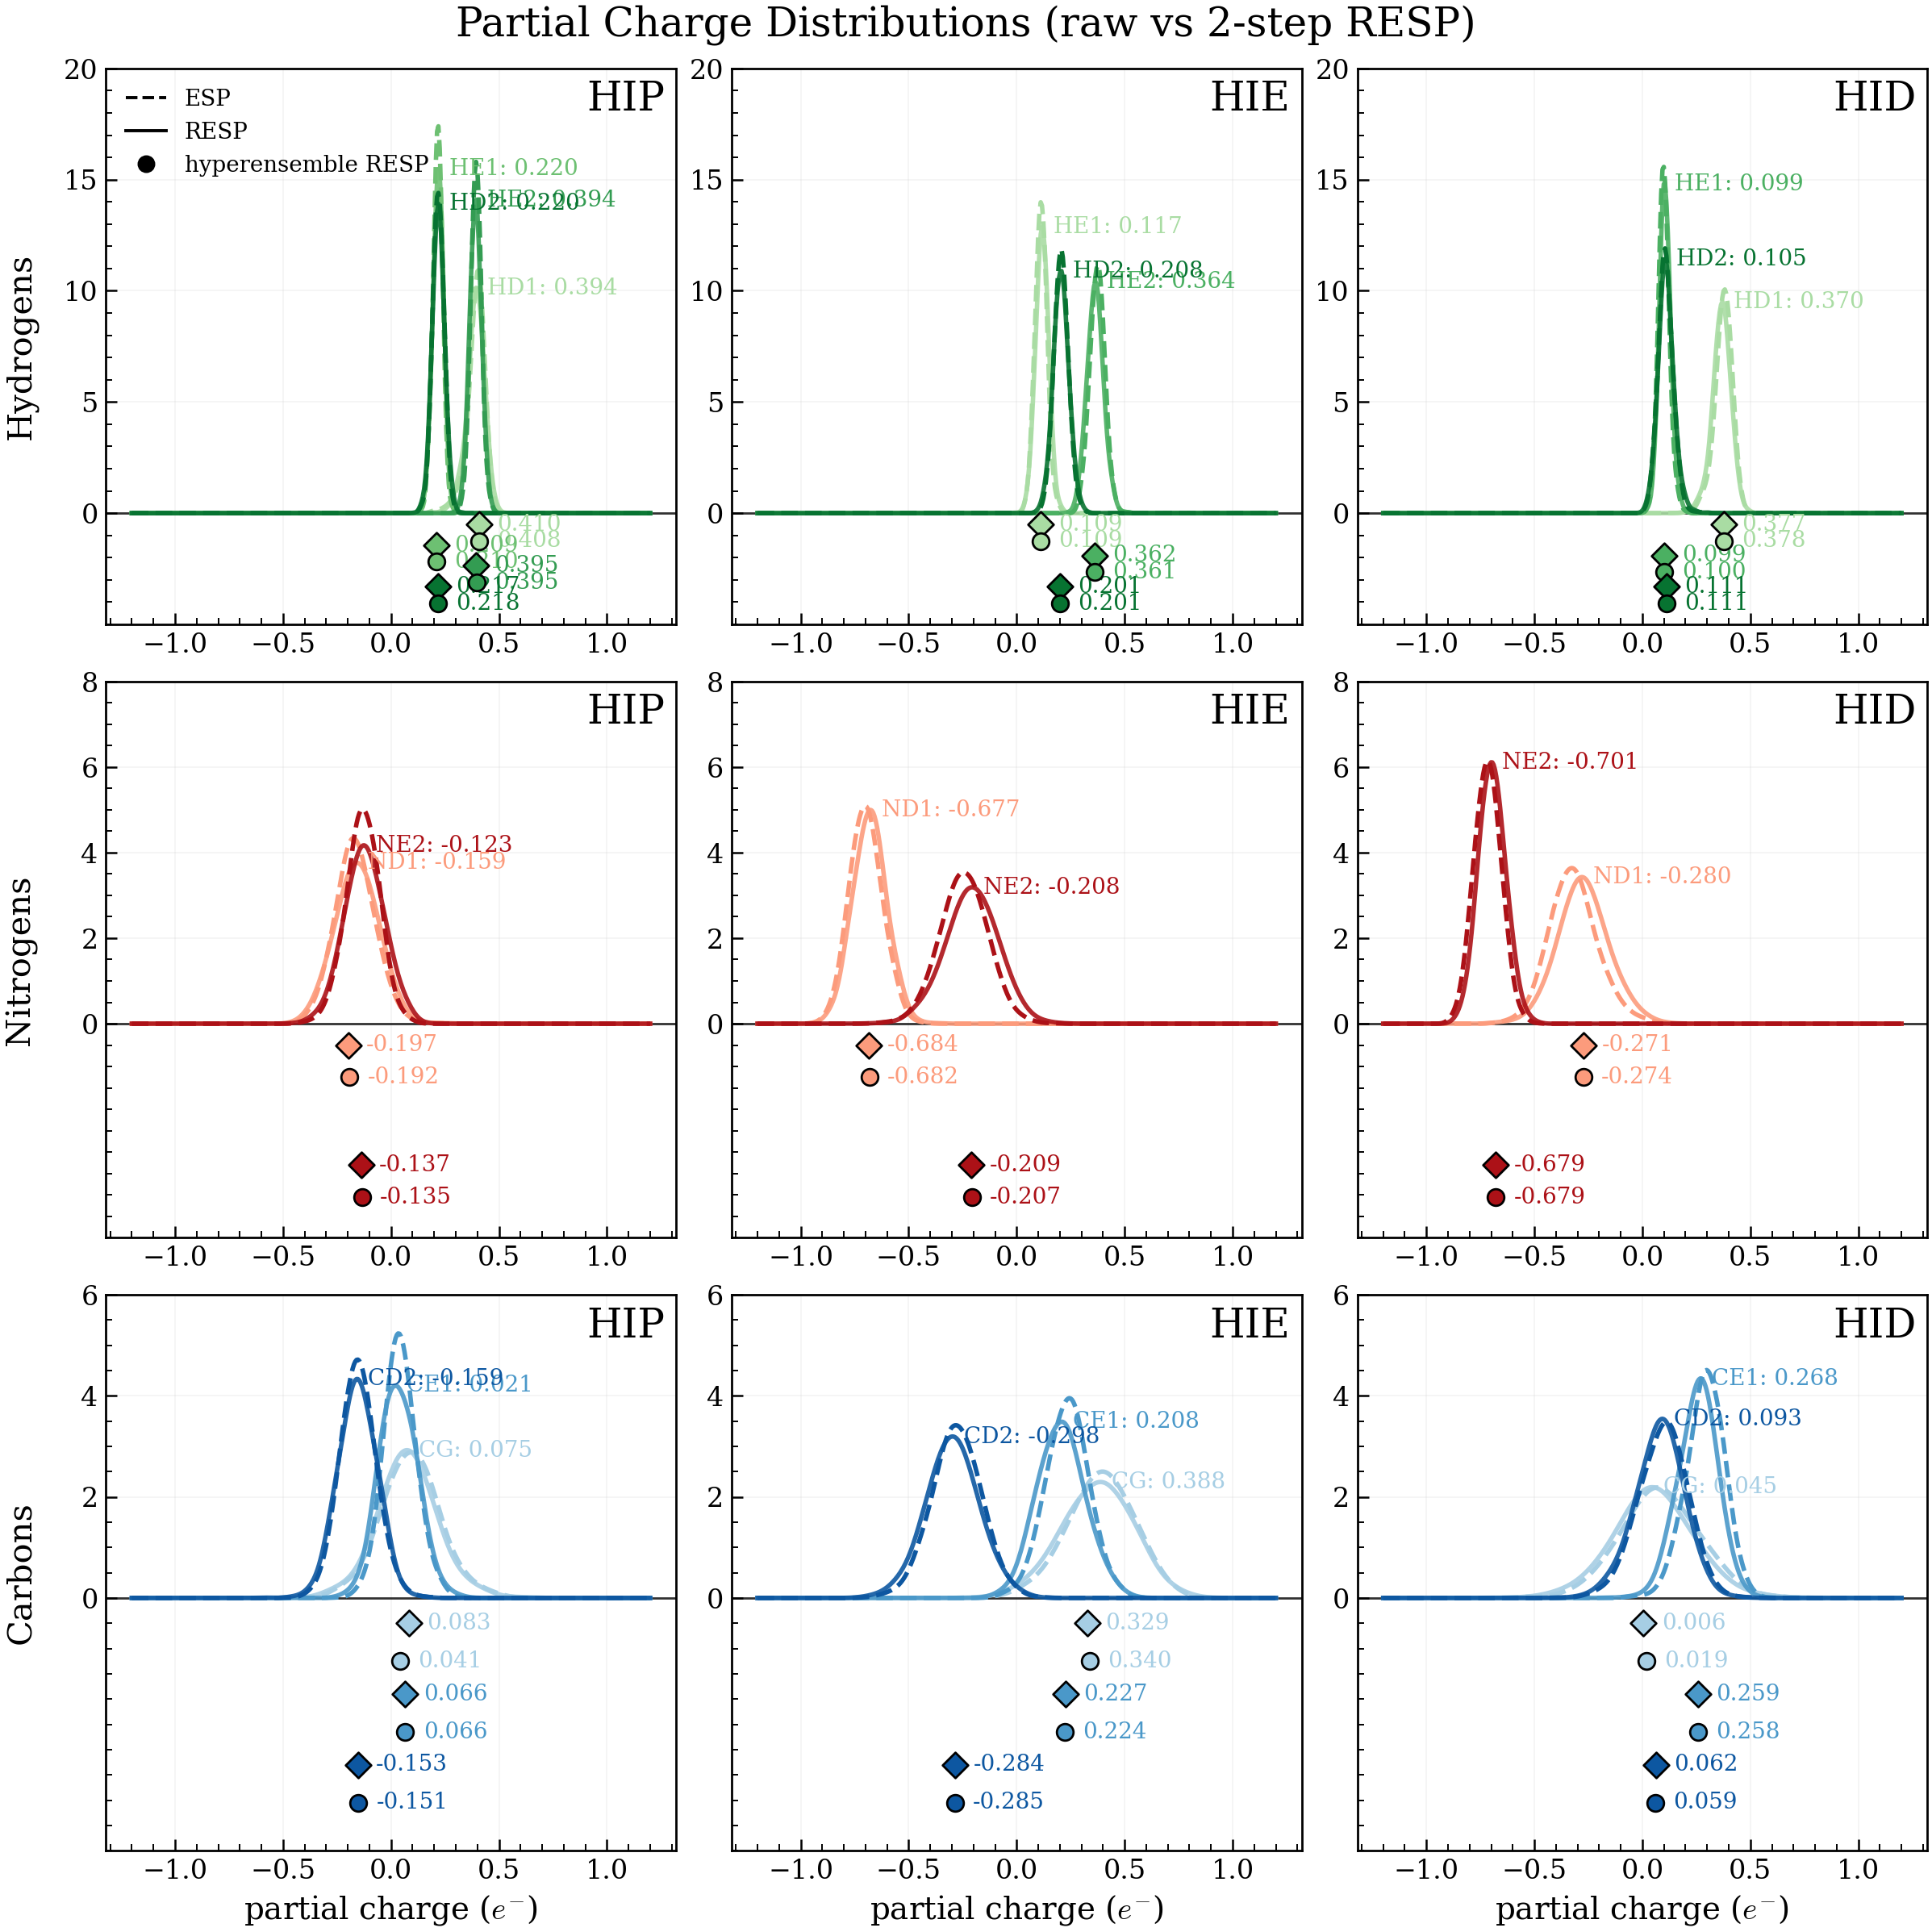

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.reshape(3, 3)

bins   = np.linspace(-1.2, 1.2, 50)
x_grid = np.linspace(bins[0], bins[-1], 400)

element_datasets = [hydro_dataset, nitrogen_dataset, carbon_dataset]
row_titles       = ["Hydrogens", "Nitrogens", "Carbons"]

row_cmaps = {
    "Hydrogens": plt.cm.Greens,
    "Nitrogens": plt.cm.Reds,
    "Carbons":   plt.cm.Blues,
}

microstate_labels = ['HIP', 'HIE', 'HID']

for row, (edata, row_title) in enumerate(zip(element_datasets, row_titles)):
    cmap = row_cmaps[row_title]

    for col, state in enumerate(MICROSTATES):   # ["PRN_prot", "PRN_deprot"]
        ax = axes[row, col]

        if row == 0:          # hydrogens
            ax.set_ylim(-5, 18)
        elif row == 1:        # nitrogens
            ax.set_ylim(-5, 7)
        elif row == 2:        # carbons
            ax.set_ylim(-5, 6)

        labels      = edata[state]["labels"]
        raw_charges = edata[state]["raw_charges"]      # (n_atoms, n_frames)
        tsresp      = edata[state]["tsresp_charges"]   # (n_atoms, n_frames)
        mccharges = edata[state]["mcresp_charges"]
        mmresp_charges = edata[state]["mmresp_charges"]   # (n_atoms,)

        n_atoms = len(labels)
        if n_atoms == 0:
            ax.axis("off")
            continue

        colors = cmap(np.linspace(0.35, 0.85, n_atoms))

        # microstate label (top right)
        pretty_label = microstate_labels[col]

        ax.text(
            0.98, 0.98, pretty_label,
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=18,
        )

        # element label on left column
        if col == 0:
            ax.text(
                -0.12, 0.5, row_title,
                transform=ax.transAxes,
                ha="right", va="center",
                fontsize=15,
                rotation=90,
            )

        ax.grid(alpha=0.3)
        ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
        ax.set_yticks([0] + list(ax.get_yticks()[ax.get_yticks() > 0]))
        ax.tick_params(axis="both", labelsize=12)
        ax.axhline(0, color="black", linewidth=1, alpha=0.8)

        # --- vertical offsets for markers to avoid overlap ---
        y_top_mc  = -0.5   # highest (closest to 0) mc diamond
        y_span_mc = 2.8    # total vertical span for mc diamonds
        if n_atoms > 1:
            dy_mc = y_span_mc / (n_atoms - 1)
        else:
            dy_mc = 0.0

        delta_mm = 0.75    # mm marker sits this much below its mc diamond


        # --- per-atom curves ---
        for idx, (label, color) in enumerate(zip(labels, colors)):
            series_raw = raw_charges[idx]
            series_ts  = tsresp[idx]
            mc_val = mccharges[idx]
            mm_val     = mmresp_charges[idx]

            # raw ESP KDE (solid)
            kde_raw = gaussian_kde(series_raw)
            kde_raw.set_bandwidth(bw_method=kde_raw.factor * 1.75)
            density_raw = kde_raw(x_grid)

            line_raw, = ax.plot(
                x_grid,
                density_raw,
                color=color,
                linestyle="--",
                linewidth=2,
            )

            # two-step RESP KDE (dashed)
            kde_ts = gaussian_kde(series_ts)
            kde_ts.set_bandwidth(bw_method=kde_ts.factor * 1.75)
            density_ts = kde_ts(x_grid)

            # annotate at KDE peak (like your example)
            peak_idx = np.argmax(density_ts)
            x_peak   = x_grid[peak_idx]
            y_peak   = density_ts[peak_idx]

            ax.annotate(
                f"{label}: {x_peak:.3f}",
                xy=(x_peak, y_peak),
                xytext=(5, 0),
                textcoords="offset points",
                color=color,
                fontsize=10,
                ha="left",
                va="center",
            )

            ax.plot(
                x_grid,
                density_ts,
                color=color,
                linestyle="-",
                linewidth=2,
                alpha=0.9,
            )

            
            # -------------------------------
            # offsets for this atom's markers
            # -------------------------------
            y_mc = y_top_mc - dy_mc * idx     # mc diamond y
            y_mm = y_mc - delta_mm            # mm marker just below

            # mcRESP: diamond + value
            ax.scatter(
                mc_val, y_mc,
                marker="D",
                s=65,
                color=color,
                edgecolor="k",
                zorder=6,
            )
            ax.annotate(
                f"{mc_val:.3f}",
                xy=(mc_val, y_mc),
                xytext=(8, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=10,
                color=color,
            )

            # mmRESP: circle + value
            ax.scatter(
                mm_val, y_mm,
                marker="o",
                s=55,
                color=color,
                edgecolor="k",
                zorder=6,
            )
            ax.annotate(
                f"{mm_val:.3f}",
                xy=(mm_val, y_mm),
                xytext=(8, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=10,
                color=color,
            )


        # x-label only on bottom row
        if row == 2:
            ax.set_xlabel(r"partial charge ($e^{-}$)", fontsize=14)

# line-style legend only (no atom legend; labels are on the curves)
axes[0, 0].plot([], [], "k--",  label="ESP")
axes[0, 0].plot([], [], "k-", label="RESP")
axes[0, 0].legend(frameon=False, fontsize=10, loc="upper left")
axes[0, 0].plot([], [], marker="o", linestyle="", color="k",
                markersize=7, label="hyperensemble RESP")
axes[0, 0].legend(frameon=False, fontsize=10, loc="upper left")

fig.suptitle(
    "Partial Charge Distributions (raw vs 2-step RESP)",
    fontsize=18,
)

#fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("../reports/histidine.png", dpi=300)
#plt.show()